# Create Network for Main Path Creation in Pajek


In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv("PYTHONPATH")
data_dir = os.getenv("DATA_DIR")
src_dir = os.getenv("SRC_DIR")
output_dir = os.getenv("OUTPUT_DIR")

import json
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from src.network.creation.PajekNetworkCreator import PajekNetworkCreator
from src.network.creation.PajekNetworkCreatorUtils import (
    PajekNetworkCreatorUtils as utils,
)

# show all columns
pd.set_option("display.max_columns", None)

In [2]:
# read in G
p = data_dir + "/05-graphs/citation-graph/directed_citation_graph.graphml"
G_directed = nx.read_graphml(p)

G_analysis = nx.read_graphml(data_dir + "/08-analysis-data/graph_analysis.graphml")
print("Original Graph")
print(G_directed)
print("Analysis Graph")
print(G_analysis)

Original Graph
DiGraph with 38961 nodes and 355263 edges
Analysis Graph
Graph with 36510 nodes and 551227 edges


# Filter G_directed to keep only nodes that exist in G_analysis


In [ ]:
def filter_graph_by_node_ids(original_graph, reference_graph, id_attribute="eid"):
    """
    Filter the original graph to keep only nodes that exist in the reference graph,
    based on a specific node attribute.

    Parameters:
    -----------
    original_graph : networkx.Graph
        The graph to be filtered
    reference_graph : networkx.Graph
        The graph containing the reference nodes
    id_attribute : str, default='eid'
        The node attribute to use for matching nodes between graphs

    Returns:
    --------
    networkx.Graph
        A subgraph of the original graph containing only nodes present in the reference graph
    """
    # Extract IDs from reference graph
    reference_ids = [node[1][id_attribute] for node in reference_graph.nodes(data=True)]

    # Create a list of nodes to keep in the original graph
    nodes_to_keep = [
        node
        for node, data in original_graph.nodes(data=True)
        if data[id_attribute] in reference_ids
    ]

    # Create a subgraph with only the nodes to keep
    filtered_graph = original_graph.subgraph(nodes_to_keep).copy()

    print(
        f"Original graph: {original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    )
    print(
        f"Filtered graph: {filtered_graph.number_of_nodes()} nodes, {filtered_graph.number_of_edges()} edges"
    )

    return filtered_graph

In [ ]:
# Filter G_directed to keep only nodes that exist in G_analysis
G_directed_ana = filter_graph_by_node_ids(G_directed, G_analysis, id_attribute="eid")

Original graph: 38961 nodes, 355263 edges
Filtered graph: 36510 nodes, 338084 edges


# clean graph

- clean attributes
- remove loops by creating familiy nodes (see Liu 2019)
- remove isolates
  extract largest weakly connected component (WCC)


In [ ]:
creator = PajekNetworkCreator(
    G_directed_ana,
)
Gpjk, log = creator.prepare_pajek()

print(f"Original number of nodes: {G_directed_ana.number_of_nodes()}")
print(f"Original number of edges: {G_directed_ana.number_of_edges()}")
print(f"New number of nodes: {Gpjk.number_of_nodes()}")
print(f"New number of edges: {Gpjk.number_of_edges()}")

print(f" Removed bc loops: {log['loops_removed']['count']}")
print(f" Removed bc isolates: {log['isolates_removed']['count']}")
print(f" Removed bc largest wcc: {log['largest_wcc_removed']['count']}")

Original number of nodes: 36510
Original number of edges: 338084
New number of nodes: 34366
New number of edges: 335884
 Removed bc loops: 69
 Removed bc isolates: 1926
 Removed bc largest wcc: 102


# Resolve family issues

**PROBLEM**: Some large families are built due to updated cochane reviews. They are updated and this creates citation loops and bidirectional citations. This is a problem for the main path analysis.

We solve it the following way:

1. we keep families of up to three members.
2. we keep families of greater sizes if they are all published in the same journal issue.
3. Families due to updated cochrane reviews are dissolved by removing edges.
   1. Bidirectional edges are removed, the edge that is going against time is removed.
   2. Other edges that are counterchronological are removed until the cycle is dissolved.


In [3]:
p = data_dir + "/08-analysis-data/df_analysis.pkl"
df = pd.read_pickle(p)

In [ ]:
def process_loop_families(Gpjk, df):
    """
    Process loop families in the graph and generate statistics about them.

    Parameters:
    -----------
    Gpjk : networkx.Graph
        The graph containing family nodes
    df : pandas.DataFrame
        DataFrame containing paper/article information

    Returns:
    --------
    tuple
        (loop_log, df_family_dict) where:
        - loop_log is a dictionary with statistics about the loops
        - df_family_dict is a dictionary mapping family labels to their info
    """
    # Initialize loop_log
    loop_log = {
        "nr_of_loops": 0,
        "special_issue_loops": 0,
        "sizes_counts": Counter(),
        "no_special_issue_and_more_than_3": 0,
        "cochrane_update_loops": 0,
    }

    df_family_dict = {}

    for node in Gpjk.nodes(data=True):
        label = node[0]
        if label.startswith("family"):
            # Create loop dataframe
            df_loop = utils.loop_to_df(node, df).reset_index(drop=True)

            # Update loop_log
            loop_log["nr_of_loops"] += 1
            loop_log["sizes_counts"].update([df_loop.shape[0]])

            # Check for special issue
            journals = df_loop["journal"].unique()
            cochrane = any(
                "cochrane" in journal.lower() for journal in journals if journal
            )
            loop_log["cochrane_update_loops"] += cochrane
            if len(journals) == 1:
                special_issue = True
                loop_log["special_issue_loops"] += 1
            else:
                special_issue = False

            # Check for dissolving condition
            to_dissolve = not len(journals) == 1 and df_loop.shape[0] > 3

            # Store family information
            df_family_dict[label] = {
                "df": df_loop,
                "special_issue": special_issue,
                "to_dissolve": to_dissolve,
            }

    # Calculate no_special_issue_and_more_than_3
    loop_log["no_special_issue_and_more_than_3"] = sum(
        family_info["to_dissolve"] for family_info in df_family_dict.values()
    )

    return loop_log, df_family_dict


loop_log, df_family_dict = process_loop_families(Gpjk, df)

# Take closer look at loops to dissolve


# Families to fix


In [ ]:
removed_edges = []

for k, v in df_family_dict.items():
    if v["to_dissolve"]:
        print(k)
        print("-" * 40)

family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006
----------------------------------------
family_Aydemir_2011_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Cipriani_2012_2_Gibiino_2012_Hetrick_2007_Klinger_2011_Kronenberg_2008_Lavretsky_2010_Magni_2013_Omori_2010_Ou_2011_Purgato_2014_Schneeweiss_2010_2_Sie_2012_Soares_2010_Yang_2010_4_Zisook_2010
----------------------------------------
family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013
----------------------------------------
family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2
----------------------------------------
family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017
----------------------------------------


# family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006


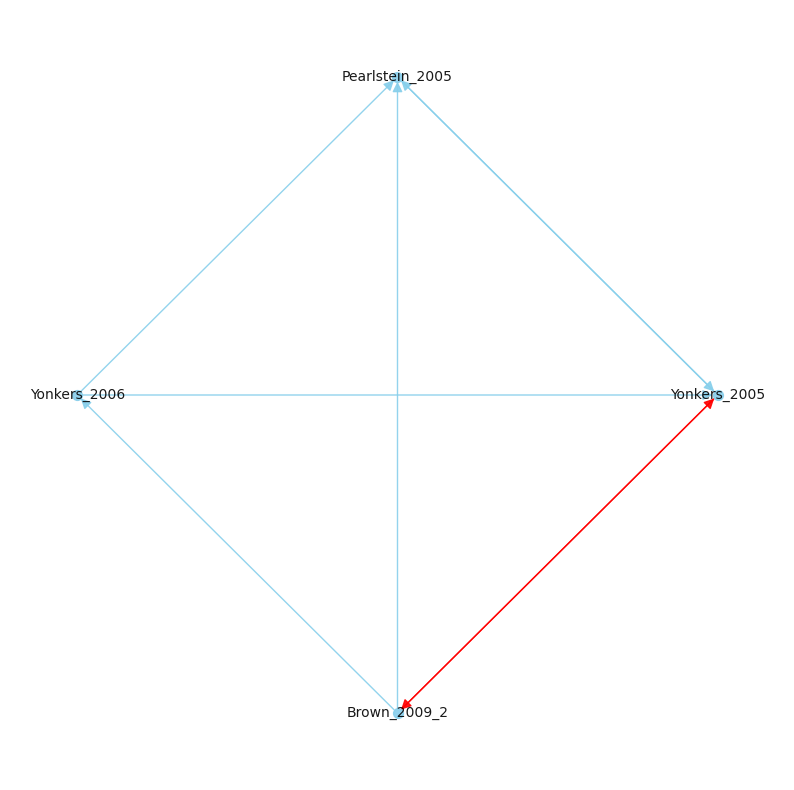

Reverse timed citation edges:
('Yonkers_2005', 'Brown_2009_2')
Cochrane Reviews:  Brown_2009_2


In [ ]:
fam = "family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

True
Removed bidirectional edge:  ('Yonkers_2005', 'Brown_2009_2')
Bidirectional edges removed: 1
True
False


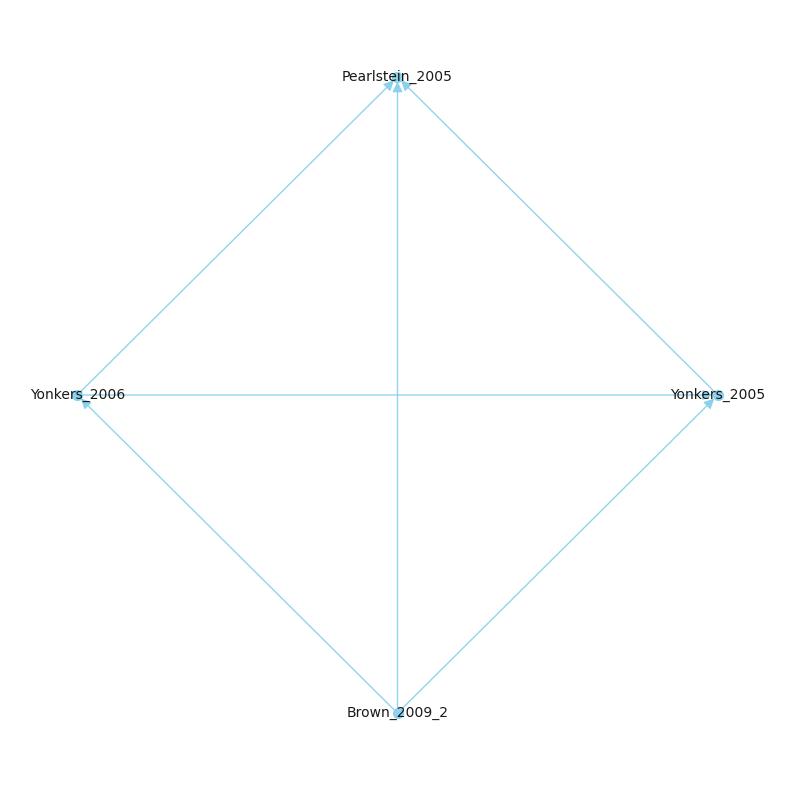

In [ ]:
print(utils.G_is_a_cycle(G))
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))


removed_edges.append(bidirectional_edges_removed)

print(utils.G_is_a_cycle(G))

edge_to_remove = ("Pearlstein_2005", "Yonkers_2005")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)

print(utils.G_is_a_cycle(G))

utils.draw_graph(G)

# family_Aydemir_2011_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Cipriani_2012_2_Gibiino_2012_Hetrick_2007_Klinger_2011_Kronenberg_2008_Lavretsky_2010_Magni_2013_Omori_2010_Ou_2011_Purgato_2014_Schneeweiss_2010_2_Sie_2012_Soares_2010_Yang_2010_4_Zisook_2010


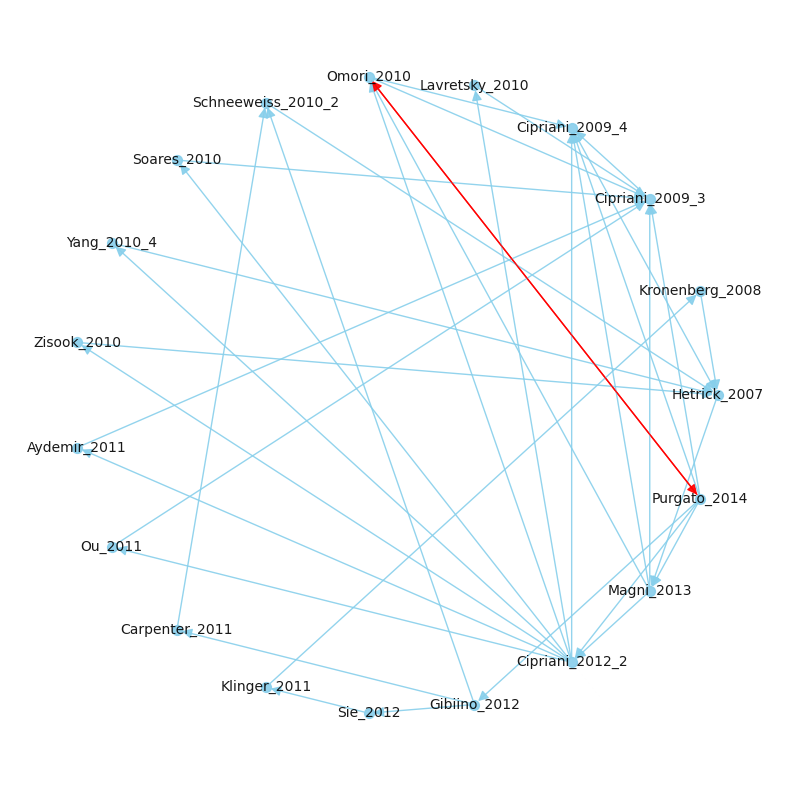

Reverse timed citation edges:
('Hetrick_2007', 'Magni_2013')
('Omori_2010', 'Purgato_2014')
Cochrane Reviews:  Hetrick_2007; Cipriani_2009_3; Cipriani_2009_4; Omori_2010; Cipriani_2012_2; Magni_2013; Purgato_2014


In [ ]:
fam = "family_Aydemir_2011_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Cipriani_2012_2_Gibiino_2012_Hetrick_2007_Klinger_2011_Kronenberg_2008_Lavretsky_2010_Magni_2013_Omori_2010_Ou_2011_Purgato_2014_Schneeweiss_2010_2_Sie_2012_Soares_2010_Yang_2010_4_Zisook_2010"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [ ]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

removed_edges.append(bidirectional_edges_removed)

print(utils.G_is_a_cycle(G))

edge_to_remove = ("Hetrick_2007", "Magni_2013")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)

print(utils.G_is_a_cycle(G))

Removed bidirectional edge:  ('Omori_2010', 'Purgato_2014')
Bidirectional edges removed: 1
True
False


# family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013


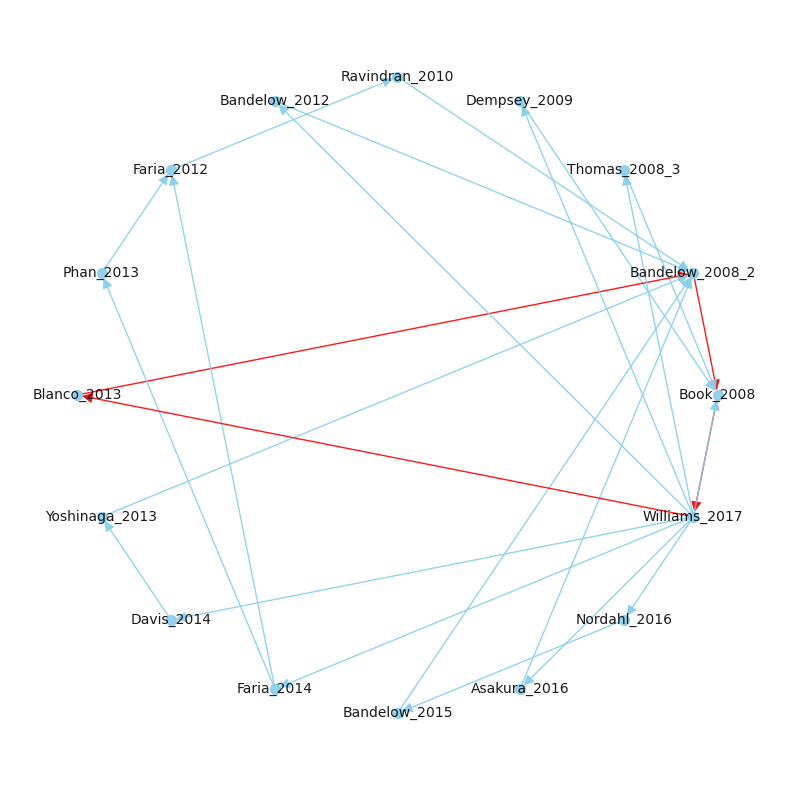

Reverse timed citation edges:
('Book_2008', 'Williams_2017')
Cochrane Reviews:  Williams_2017


In [ ]:
fam = "family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

# family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2


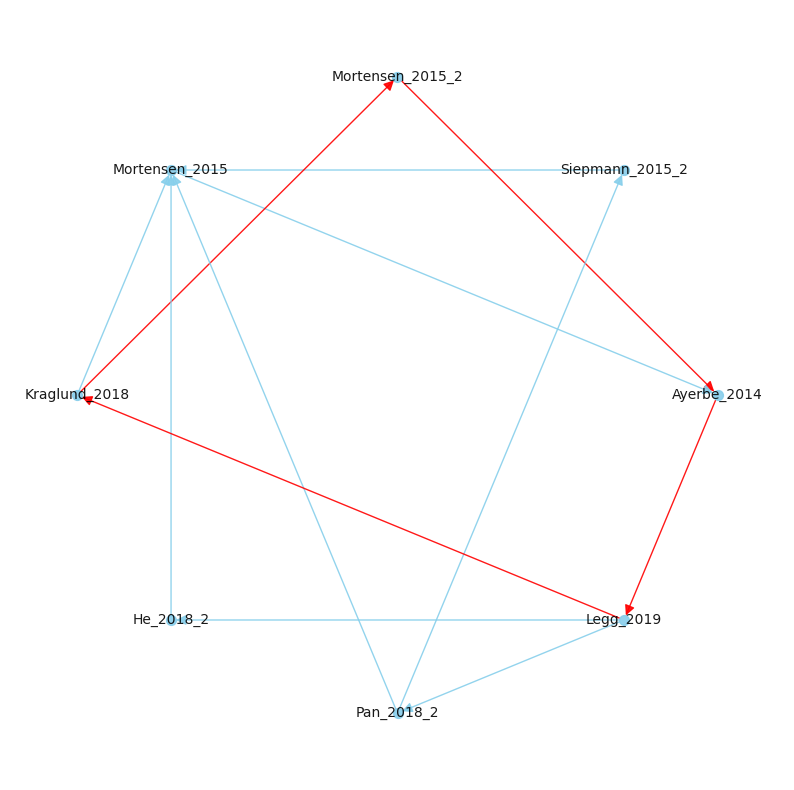

Reverse timed citation edges:
('Ayerbe_2014', 'Legg_2019')
Cochrane Reviews:  Legg_2019


In [ ]:
fam = "family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2"

df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

In [ ]:
G, bidirectional_edges_removed = utils.remove_reverse_time_bidirectional_edge(G)
print("Bidirectional edges removed:", len(bidirectional_edges_removed))

removed_edges.append(bidirectional_edges_removed)

edge_to_remove = ("Ayerbe_2014", "Legg_2019")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
    utils.draw_graph(G)
else:
    print("No cycle found in the graph")

Bidirectional edges removed: 0
No cycle found in the graph


# family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017


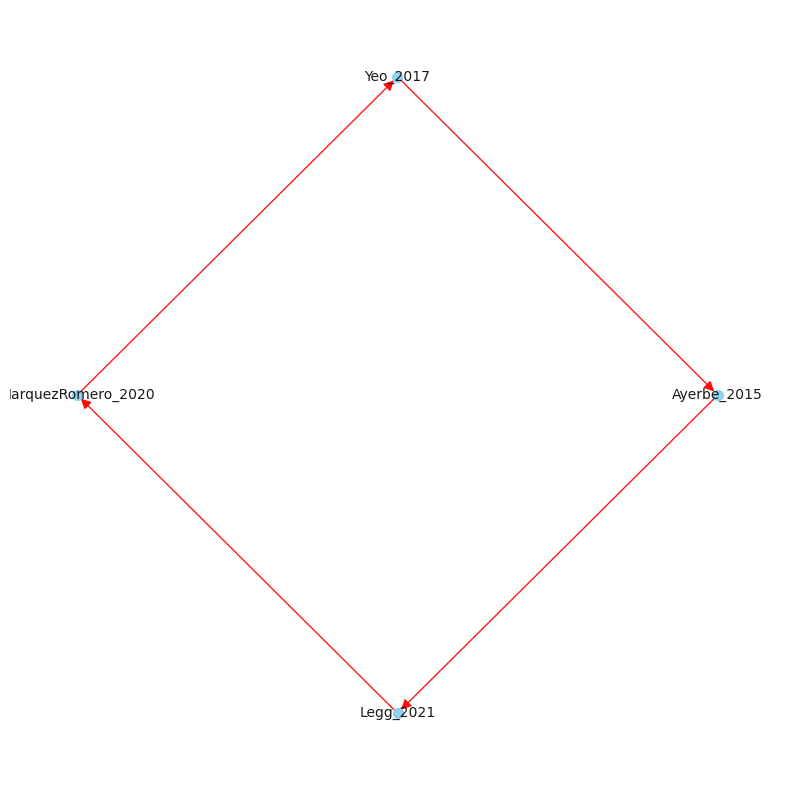

Reverse timed citation edges:
('Ayerbe_2015', 'Legg_2021')
Cochrane Reviews:  Legg_2021


In [ ]:
fam = "family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017"
df_fam = df_family_dict[fam]["df"]

G, reversed_edges = utils.create_graph_from_family(df_fam)

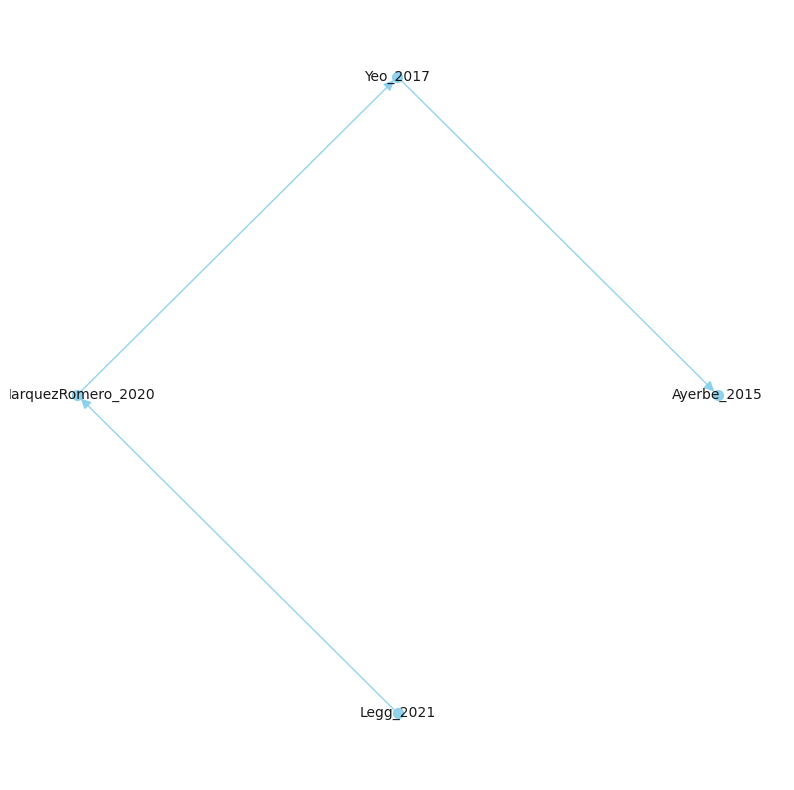

In [ ]:
# remove bidirectional edges
edge_to_remove = ("Ayerbe_2015", "Legg_2021")
G.remove_edge(edge_to_remove[0], edge_to_remove[1])
removed_edges.append(edge_to_remove)

if utils.G_is_a_cycle(G):
    print("Cycle found in the graph")
utils.draw_graph(G)

# Build network anew


In [ ]:
removed_edges

[[('Yonkers_2005', 'Brown_2009_2')],
 ('Pearlstein_2005', 'Yonkers_2005'),
 [('Omori_2010', 'Purgato_2014')],
 ('Hetrick_2007', 'Magni_2013'),
 [],
 ('Ayerbe_2014', 'Legg_2019'),
 ('Ayerbe_2015', 'Legg_2021')]

In [ ]:
clean_edges_removed = []
for item in removed_edges:
    # Skip empty lists
    if not item:
        continue

    # Extract tuple from list if needed
    if isinstance(item, list):
        if item and isinstance(item[0], tuple):
            item = item[0]

    # Add the tuple if it's a tuple
    if isinstance(item, tuple):
        clean_edges_removed.append(item)

clean_edges_removed

[('Yonkers_2005', 'Brown_2009_2'),
 ('Pearlstein_2005', 'Yonkers_2005'),
 ('Omori_2010', 'Purgato_2014'),
 ('Hetrick_2007', 'Magni_2013'),
 ('Ayerbe_2014', 'Legg_2019'),
 ('Ayerbe_2015', 'Legg_2021')]

In [ ]:
# remove empty lists
log["edges_removed"] = clean_edges_removed

with open(
    output_dir + "/descriptive-stats-logs/directed_network_info_log_pajek_2025.json",
    "w",
) as f:
    json.dump(log, f)

In [ ]:
# Assuming you have your directed graph as G_directed
# And your clean list of tuples as edges_to_remove


def remove_edges_from_graph(graph, edges_list):
    """
    Remove a list of edges from a directed graph.

    Parameters:
    -----------
    graph : networkx.DiGraph
        The directed graph to remove edges from
    edges_list : list of tuples
        List of edges to remove, where each edge is a tuple (source, target)

    Returns:
    --------
    networkx.DiGraph
        The graph with edges removed
    """
    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Count edges before removal
    original_edge_count = modified_graph.number_of_edges()

    # Remove the edges
    modified_graph.remove_edges_from(edges_list)

    # Count how many edges were actually removed
    new_edge_count = modified_graph.number_of_edges()
    edges_removed = original_edge_count - new_edge_count

    print(f"Removed {edges_removed} edges from the graph")
    print(f"Original edge count: {original_edge_count}")
    print(f"New edge count: {new_edge_count}")

    return modified_graph


G_no_loops = remove_edges_from_graph(G_directed_ana, clean_edges_removed)

Removed 6 edges from the graph
Original edge count: 338084
New edge count: 338078


In [ ]:
creator = PajekNetworkCreator(
    G_no_loops,
)
Gpjk_no_loops, log_post = creator.prepare_pajek()

loop_log_post, df_family_dict_post = process_loop_families(Gpjk_no_loops, df)

In [ ]:
loop_log_post

{'nr_of_loops': 65,
 'special_issue_loops': 42,
 'sizes_counts': Counter({2: 60, 4: 2, 3: 2, 16: 1}),
 'no_special_issue_and_more_than_3': 1,
 'cochrane_update_loops': 4}

In [ ]:
df_family_dict_post

{'family_Boeck_1982_Pedersen_1982': {'df':   unique_auth_year                              journal                eid  \
  0    Pedersen_1982                   Psychopharmacology  2-s2.0-0019989539   
  1       Boeck_1982  Acta Pharmacologica et Toxicologica  2-s2.0-0020047901   
  
                                                 title  citedby_count  \
  0  Citalopram, a selective serotonin reuptake inh...             62   
  1  Studies on Acute Toxicity and Drug Levels of C...             34   
  
                                        reference_eids  nr_references  \
  0  [2-s2.0-0014931526, 2-s2.0-0015590080, 2-s2.0-...             23   
  1  [2-s2.0-34250413044, 2-s2.0-0016900446, 2-s2.0...             16   
  
    filtered_reference_eids                                            api_url  \
  0     [2-s2.0-0020047901]  https://api.elsevier.com/content/abstract/scop...   
  1     [2-s2.0-0019989539]  https://api.elsevier.com/content/abstract/scop...   
  
                       

In [ ]:
df_family_dict.keys()
dissolve = 0
for k, v in df_family_dict.items():
    if v["to_dissolve"]:
        print(k)
        print("-" * 40)
        dissolve += 1

if dissolve == 0:
    print("No family to dissolve")

family_Brown_2009_2_Pearlstein_2005_Yonkers_2005_Yonkers_2006
----------------------------------------
family_Aydemir_2011_Carpenter_2011_Cipriani_2009_3_Cipriani_2009_4_Cipriani_2012_2_Gibiino_2012_Hetrick_2007_Klinger_2011_Kronenberg_2008_Lavretsky_2010_Magni_2013_Omori_2010_Ou_2011_Purgato_2014_Schneeweiss_2010_2_Sie_2012_Soares_2010_Yang_2010_4_Zisook_2010
----------------------------------------
family_Asakura_2016_Bandelow_2008_2_Bandelow_2012_Bandelow_2015_Blanco_2013_Book_2008_Davis_2014_Dempsey_2009_Faria_2012_Faria_2014_Nordahl_2016_Phan_2013_Ravindran_2010_Thomas_2008_3_Williams_2017_Yoshinaga_2013
----------------------------------------
family_Ayerbe_2014_He_2018_2_Kraglund_2018_Legg_2019_Mortensen_2015_Mortensen_2015_2_Pan_2018_2_Siepmann_2015_2
----------------------------------------
family_Ayerbe_2015_Legg_2021_MarquezRomero_2020_Yeo_2017
----------------------------------------


create families again


In [ ]:
# save to pajek
p = data_dir + "/05-graphs/citation-graph/directed_citation_graph_loopless_pjk.net"
nx.write_pajek(Gpjk, p)

/opt/homebrew/Caskroom/miniconda/base/envs/bibliometrics/lib/python3.11/site-packages/networkx/readwrite/pajek.py:75: UserWarning: Node attribute unique_auth_year is not processed. Empty attribute.
  warnings.warn(


# NEW ATTEMPT


In [ ]:
class PajekNetworkCreator:
    def __init__(self, G):
        self.OG = G
        self.NG = G.copy()
        self.log = {}
        self.df_family_dict = {}

    def prepare_attributes(self):
        for node, data in self.NG.nodes(data=True):
            for k, v in data.items():
                data[k] = str(v)

    def analyze_family(self, scc, df):
        """Analyze a strongly connected component to determine if it should be a family"""
        # Get all nodes in the SCC
        nodes = list(scc)

        # Create dataframe for the family
        eids = [
            self.NG.nodes[node]["eid"] for node in nodes if "eid" in self.NG.nodes[node]
        ]
        df_family = df[df["eid"].isin(eids)]

        # Analyze family characteristics
        family_info = {
            "size": len(nodes),
            "journals": df_family["journal"].unique(),
            "is_cochrane": any(
                "cochrane" in str(j).lower() for j in df_family["journal"]
            ),
            "years": [int(node.split("_")[1]) for node in nodes],
            "nodes": nodes,
        }

        # Determine if this should be a family
        family_info["should_be_family"] = (
            len(nodes) <= 3  # Small families are always kept
            or (
                len(family_info["journals"]) == 1 and len(nodes) <= 5
            )  # Special issues up to 5 papers
            or (
                family_info["is_cochrane"] and len(nodes) <= 4
            )  # Cochrane reviews up to 4 papers
        )

        return family_info

    def remove_loops(self, df):
        """Remove loops while preserving important citation relationships"""
        # Find all SCCs
        sccs = list(nx.strongly_connected_components(self.NG))

        # Create a new graph without loops
        Gloopless = nx.DiGraph()
        self.original_to_family = {}
        removed_edges = []

        # Process each SCC
        for scc in sccs:
            if len(scc) > 1:  # Only process actual loops
                # Analyze the family
                family_info = self.analyze_family(scc, df)

                if family_info["should_be_family"]:
                    # Create family node
                    family_node = "family_" + "_".join(
                        sorted([str(node) for node in scc])
                    )

                    # Add family node with combined attributes
                    eids = ";".join(
                        [
                            self.NG.nodes[node]["eid"]
                            for node in scc
                            if "eid" in self.NG.nodes[node]
                        ]
                    )
                    unique_auth_year = ";".join(
                        [
                            str(self.NG.nodes[node]["unique_auth_year"])
                            for node in scc
                            if "unique_auth_year" in self.NG.nodes[node]
                        ]
                    )

                    Gloopless.add_node(
                        family_node, eid=eids, unique_auth_year=unique_auth_year
                    )

                    # Map original nodes to family
                    for node in scc:
                        self.original_to_family[node] = family_node

                    # Store family info
                    self.df_family_dict[family_node] = family_info
                else:
                    # Dissolve the family by removing problematic edges
                    subgraph = self.NG.subgraph(scc)

                    # First collect edges to remove that go against time
                    edges_to_remove = []
                    for u, v in list(
                        subgraph.edges()
                    ):  # Convert to list to avoid modification during iteration
                        year1 = int(u.split("_")[1])
                        year2 = int(v.split("_")[1])
                        if year2 > year1:
                            edges_to_remove.append((u, v))

                    # Remove the collected edges
                    for u, v in edges_to_remove:
                        self.NG.remove_edge(u, v)
                        removed_edges.append((u, v))

                    # If still a cycle, collect and remove edges based on citation count
                    if nx.is_strongly_connected(subgraph):
                        citation_counts = {
                            node: self.NG.nodes[node].get("citedby_count", 0)
                            for node in scc
                        }
                        edges_to_remove = []
                        for u, v in list(
                            subgraph.edges()
                        ):  # Convert to list to avoid modification during iteration
                            if citation_counts[u] < citation_counts[v]:
                                edges_to_remove.append((u, v))

                        # Remove the collected edges
                        for u, v in edges_to_remove:
                            self.NG.remove_edge(u, v)
                            removed_edges.append((u, v))

                    # Add individual nodes
                    for node in scc:
                        Gloopless.add_node(node, **self.NG.nodes[node])
                        self.original_to_family[node] = node
            else:
                # Single node, just add it
                node = next(iter(scc))
                Gloopless.add_node(node, **self.NG.nodes[node])
                self.original_to_family[node] = node

        # Add edges between nodes/families
        for u, v, data in self.NG.edges(data=True):
            new_u = self.original_to_family.get(u, u)
            new_v = self.original_to_family.get(v, v)
            if new_u != new_v:
                Gloopless.add_edge(new_u, new_v, **data)

        # Update the graph and log
        self.NG = Gloopless
        self.log["loops_removed"] = {
            "count": len(removed_edges),
            "edges": removed_edges,
            "families_created": len(self.df_family_dict),
            "family_sizes": Counter(
                info["size"] for info in self.df_family_dict.values()
            ),
        }

    def remove_isolates(self):
        """Remove isolated nodes"""
        isolates = list(nx.isolates(self.NG))
        isolated_eids = [self.NG.nodes[iso]["eid"] for iso in isolates]
        self.NG.remove_nodes_from(isolates)
        self.log["isolates_removed"] = {"count": len(isolates), "eids": isolated_eids}

    def extract_largest_wcc(self):
        """Extract the largest weakly connected component"""
        largest_wcc = max(nx.weakly_connected_components(self.NG), key=len)
        removed_nodes = set(self.NG.nodes()) - set(largest_wcc)
        removed_eids = [self.NG.nodes[node]["eid"] for node in removed_nodes]
        self.NG = self.NG.subgraph(largest_wcc).copy()
        self.log["largest_wcc_removed"] = {
            "count": len(removed_nodes),
            "eids": removed_eids,
        }

    def prepare_pajek(self, df):
        """Prepare the network for Pajek format"""
        self.prepare_attributes()
        self.remove_loops(df)
        self.remove_isolates()
        self.extract_largest_wcc()
        return self.NG, self.log


creator = PajekNetworkCreator(G_directed_ana)

Gpjk, log = creator.prepare_pajek(df)

save_path = (
    data_dir + "/10-main-path-graphs/directed_citation_graph_loopless_pjk_2025.net"
)

nx.write_pajek(Gpjk, save_path)

/opt/homebrew/Caskroom/miniconda/base/envs/bibliometrics/lib/python3.11/site-packages/networkx/readwrite/pajek.py:75: UserWarning: Node attribute unique_auth_year is not processed. Empty attribute.
  warnings.warn(


In [ ]:
# Check for remaining loops
def check_for_loops(G):
    """Check if the graph contains any loops and return information about them"""
    # Find all strongly connected components with more than 1 node
    sccs = [scc for scc in nx.strongly_connected_components(G) if len(scc) > 1]

    if not sccs:
        print("No loops found in the graph!")
        return None

    print(f"Found {len(sccs)} loops in the graph:")
    for i, scc in enumerate(sccs, 1):
        print(f"\nLoop {i}:")
        print(f"Size: {len(scc)} nodes")

        # Get the subgraph for this SCC
        subgraph = G.subgraph(scc)

        # Print node information
        print("Nodes in loop:")
        for node in scc:
            year = node.split("_")[1] if "_" in node else "unknown"
            print(f"  - {node} (Year: {year})")

        # Print edge information
        print("\nEdges in loop:")
        for u, v in subgraph.edges():
            year1 = u.split("_")[1] if "_" in u else "unknown"
            year2 = v.split("_")[1] if "_" in v else "unknown"
            print(f"  - {u} -> {v} (Years: {year1} -> {year2})")

        # Check if it's a family node
        if any(node.startswith("family_") for node in scc):
            print("Contains family nodes")

    return sccs


# Run the check
remaining_loops = check_for_loops(Gpjk)

# If you want to visualize specific loops
if remaining_loops:
    # Visualize the first loop as an example
    first_loop = Gpjk.subgraph(next(iter(remaining_loops)))
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(first_loop)
    nx.draw(
        first_loop,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=500,
        font_size=8,
        arrowsize=20,
    )
    plt.title("Example of Remaining Loop")
    plt.show()

No loops found in the graph!
